This notebook demonstrates using SNMR data to produce transmissivity maps for each aquifer in the East Kimberley Keep s74 area.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * df['Total_water_content'].values * df['T2*'].values

def point_within_bounds(x,y, bounds):
    if (bounds.left < x) & (bounds.right > x):
        if (bounds.bottom < y) & (bounds.top > y):
            return True
    return False

In [4]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database


SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']


DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR-test.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              s.geometry,
              s.elevation,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID";"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]


In [5]:
# Here we will join on modelled water table elevations from a spreadsheet

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\results\KR_water_table_interpolation_ready.csv"

df_wte = pd.read_csv(infile)

# Mask out non SNMR sites
df_wte = df_wte[df_wte['source'] == 'SNMR_modelled']

df_wte = df_wte.rename(columns = {'id':
                                  'Field_ID'})

In [6]:
df_wte

,Field_ID,Easting,Northing,wt_depth,wt_mAHD,uncertainty,source,elev_mAHD
3,OK18_64,499984.0352,8275905.720,15.052675,12.448536,4.0,SNMR_modelled,27.501211
4,OK18_63,502559.4414,8276276.844,16.872404,9.436611,4.0,SNMR_modelled,26.309015
8,KCP_t2_s4,498604.5356,8279106.967,13.082195,11.552296,4.0,SNMR_modelled,24.634491
9,OK18_62,497945.1786,8281445.705,15.052675,7.209666,4.0,SNMR_modelled,22.262341
11,KCP_nst1_s5,497381.6525,8284248.740,10.465410,10.748518,4.0,SNMR_modelled,21.213928
14,OK18_70,499206.4563,8286306.341,10.387130,9.096518,4.0,SNMR_modelled,19.483648
15,KCP_nst1_S3,497501.2696,8286737.473,10.465410,8.582510,4.0,SNMR_modelled,19.047920
16,OK18_71,504274.7967,8287075.191,1.102440,25.687693,4.0,SNMR_modelled,26.790133
21,WANT_t1_S4E,501171.1844,8292086.984,8.223141,11.232606,4.0,SNMR_modelled,19.455748
24,OK18_33,504855.7175,8292435.797,10.387130,7.405515,4.0,SNMR_modelled,17.792645


In [7]:
# Join
df_acquisitions = df_acquisitions.reset_index().merge(df_wte[['Field_ID', 'wt_mAHD']], on= 'Field_ID').set_index('acquisition_id')

In [8]:
df_acquisitions

,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation,wt_mAHD
acquisition_id,,,,,,,,,,
51,40,KRP_fz4_S1,510620.4141,8304741.162,"POLYGON ((510580.411342 8304781.15903, 510660....",11.1638603210449,FID,60.0,60.183712,5.665174
52,41,KRP_fz4_S2,510920.8857,8305320.149,"POLYGON ((510879.04854 8305282.07483, 510882.8...",8.85167980194092,FID,60.0,68.306915,6.430922
53,42,KRP_fz4_S3,511376.2930,8305707.189,"POLYGON ((511418.130199 8305745.26331, 511414....",10.0931987762451,FID,60.0,60.183712,4.594512
126,73,KRP_t5_s2,514186.9804,8303026.579,"POLYGON ((514145.129956 8302988.51936, 514148....",12.0784797668457,FID,80.0,60.183712,3.855338
127,74,KRP_tlwg_s6,514256.3671,8304163.589,"POLYGON ((514214.517254 8304125.52838, 514218....",11.4985599517822,FID,30.0,39.724309,4.265148
131,76,KRP_t1_s4,517018.7399,8307816.363,"POLYGON ((517060.590348 8307854.42259, 517056....",10.1194009780884,FID,80.0,49.247963,3.792935
132,77,KRP_t1_s1,515939.7896,8309311.436,"POLYGON ((515981.638111 8309349.49811, 515977....",8.58635711669922,FID,80.0,42.747987,2.259892
135,78,KRP_t4_s8,513990.8605,8301635.396,"POLYGON ((514032.710989 8301673.45589, 514028....",12.9027118682861,FID,30.0,60.183712,4.679570
137,79,KRP_t4_s1,510725.0655,8304302.638,"POLYGON ((510683.219618 8304264.57316, 510687....",11.7864770889282,FID,80.0,60.183712,5.460011


In [9]:
# Lets bring in the major surfaces in mAHD so we can start assigning observations to each SNMR observation

base_ceno = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\strat_grids\Cz_base_mAHD.tif"
top_mill = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\strat_grids\Clm_top_mAHD.tif"


In [10]:
# Now for each site we want to attribute the SNMR based on this


df_acquisitions['base_ceno'] = np.nan

df_acquisitions['top_mill'] = np.nan

# Add the layer_boundary depths to the dataframe

# Open the tif files
ceno_src = rasterio.open(base_ceno)

mill_src = rasterio.open(top_mill)



ceno_bounds = ceno_src.bounds
mill_bounds = mill_src.bounds

In [11]:
# Iterate through the sites and add the raster value to the dataframe
# if it is within the extent of the raster
for index, row in df_acquisitions.iterrows():
    # get the coords
    x, y = row.mid_X, row.mid_Y
    # Base ceno
    if point_within_bounds(x,y, ceno_bounds):
        
        baseceno = next(ceno_src.sample(np.array([[x,y]])))[0]
        

        if baseceno > -900:
            df_acquisitions.at[index, 'base_ceno'] = baseceno
    # Top Milligans
    if point_within_bounds(x,y, mill_bounds):
        
        milltop = next(mill_src.sample(np.array([[x,y]])))[0]

        if milltop > -900:
            print(milltop)
            df_acquisitions.at[index, 'top_mill'] = milltop
        

-10.0
-150.0
-15.0
0.0
-190.0
-15.0
17.168001
-150.0
-190.0
-25.0
-90.0
-15.0
-15.0
-15.0
-15.0
-190.0
-110.0
0.0
-15.0
-5.0
-10.0
-15.0
-15.0
-15.0
-15.0


In [12]:
# Drop acquisitions that are all nans
df_acquisitions_subset = df_acquisitions.dropna(subset = ['wt_mAHD'])

In [13]:
df_acquisitions_subset

,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation,wt_mAHD,base_ceno,top_mill
acquisition_id,,,,,,,,,,,,
51,40,KRP_fz4_S1,510620.4141,8304741.162,"POLYGON ((510580.411342 8304781.15903, 510660....",11.1638603210449,FID,60.0,60.183712,5.665174,-15.0,NaN
52,41,KRP_fz4_S2,510920.8857,8305320.149,"POLYGON ((510879.04854 8305282.07483, 510882.8...",8.85167980194092,FID,60.0,68.306915,6.430922,-15.0,NaN
53,42,KRP_fz4_S3,511376.2930,8305707.189,"POLYGON ((511418.130199 8305745.26331, 511414....",10.0931987762451,FID,60.0,60.183712,4.594512,0.0,NaN
126,73,KRP_t5_s2,514186.9804,8303026.579,"POLYGON ((514145.129956 8302988.51936, 514148....",12.0784797668457,FID,80.0,60.183712,3.855338,-20.0,NaN
127,74,KRP_tlwg_s6,514256.3671,8304163.589,"POLYGON ((514214.517254 8304125.52838, 514218....",11.4985599517822,FID,30.0,39.724309,4.265148,-20.0,NaN
131,76,KRP_t1_s4,517018.7399,8307816.363,"POLYGON ((517060.590348 8307854.42259, 517056....",10.1194009780884,FID,80.0,49.247963,3.792935,-5.0,NaN
132,77,KRP_t1_s1,515939.7896,8309311.436,"POLYGON ((515981.638111 8309349.49811, 515977....",8.58635711669922,FID,80.0,42.747987,2.259892,-5.0,NaN
135,78,KRP_t4_s8,513990.8605,8301635.396,"POLYGON ((514032.710989 8301673.45589, 514028....",12.9027118682861,FID,30.0,60.183712,4.679570,-5.0,NaN
137,79,KRP_t4_s1,510725.0655,8304302.638,"POLYGON ((510683.219618 8304264.57316, 510687....",11.7864770889282,FID,80.0,60.183712,5.460011,-15.0,NaN


In [14]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions_subset.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
        'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_SNMR_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_SNMR_inversions = df_SNMR_inversions.merge(df_acquisitions_subset, 
                                              how='inner', left_on='acquisition_id',
                                              right_index=True, )


In [15]:
### TODO fix datatype up in database
df_SNMR_inversions['elevation'] = df_SNMR_inversions['elevation'].astype(np.float)

In [16]:
# Create an elevation from and to column

df_SNMR_inversions['Elevation_from'] = df_SNMR_inversions['elevation'] - df_SNMR_inversions['Depth_from']
df_SNMR_inversions['Elevation_to'] = df_SNMR_inversions['elevation'] - df_SNMR_inversions['Depth_to']

In [17]:
df_SNMR_inversions['label'] = ''


# Iterate though the acquisitions and assign a labell based on the hydrostrat
for index, row in df_acquisitions_subset.iterrows():
    
    mask = df_SNMR_inversions['acquisition_id'] == index
    
    # Extract site data
    df_subset = df_SNMR_inversions[mask]

    # Break into saturated and unsaturated
    df_unsat = df_subset[df_subset['Elevation_from'] > row.wt_mAHD]
    df_sat = df_subset[df_subset['Elevation_from'] <= row.wt_mAHD]
    
    df_subset.at[df_unsat.index, 'label'] = 'unsaturated'
    
    # Some logical if statements to get labelas
    # Get Milligans if a value is picked from the surface
    if pd.notnull(row.top_mill):
        
        df_mill = df_sat[df_sat['Elevation_from'] <= row.top_mill]
        df_subset.at[df_mill.index, 'label'] = 'Milligans'
        nomill = False
        
    else:
        nomill = True
    
    # Get base of ceno if it is picked from surface
    if pd.notnull(row.base_ceno):
            
        df_ceno = df_sat[df_sat['Elevation_from'] >= row.base_ceno]
        df_subset.at[df_ceno.index, 'label'] = 'Cenozoic'
        noceno = False
    
    else:
        noceno = True
    
    # Define th permocarb not based on a surface but by the presence or absence
    # of the over/ underlying units based on logic
    if nomill & noceno:
        df_subset.at[df_sat.index, 'label'] = 'Permocarb'
    
    elif nomill:
        df_pcarb= df_sat[df_sat['Elevation_from'] <= row.base_ceno]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
        
    elif noceno:
        df_pcarb = df_sat[df_sat['Elevation_to'] >= row.top_mill]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
    
    else:
        df_pcarb = df_sat[(df_sat['Elevation_to'] >= row.top_mill) &\
                         (df_sat['Elevation_to'] <= row.base_ceno)]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
        
    # Now we substitue the labels from the subset back into the original 
    # data frame
    
    df_SNMR_inversions.at[df_subset.index, 'label'] = df_subset['label']
    
    if pd.isnull(df_subset['label']).any():
        print(df_subset)
        

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
# Unlabelled rows represent depth intervals that straddle the hydrostratigraphic
# surfaces
print((df_SNMR_inversions['label'] == '').sum())

# Reassign with transition

df_SNMR_inversions = df_SNMR_inversions.replace({'':'transition'})

4


In [19]:
# Calculate K for each unit

C_values = np.zeros(shape = len(df_SNMR_inversions['label']),
                   dtype = np.float)

# From calibrate SNMR notebook

ceno_best_c, permocarb_C = 2050., 68.

In [20]:
# Do some histrograms

unsat_mask = df_SNMR_inversions['label'] == 'unsaturated'

pcarb_mask = df_SNMR_inversions['label'] == 'Permocarb'

C_values[pcarb_mask] = permocarb_C

# Transition gets the same a permocarb
trans_mask = df_SNMR_inversions['label'] == 'transition'

C_values[trans_mask] = permocarb_C

ceno_mask = df_SNMR_inversions['label'] == 'Cenozoic'

C_values[ceno_mask] = ceno_best_c

mill_mask = df_SNMR_inversions['label'] == 'Milligans'

# Made up value
C_values[mill_mask] = 1.

In [21]:
df_SNMR_inversions['Mobile_water_content']

table_id
2450     0.008397
2451     0.008199
2452     0.000019
2453     0.000000
2454     0.003072
2455     0.010225
2456     0.013870
2457     0.007981
2458     0.012519
2459     0.014510
2460     0.022323
2461     0.010974
2462     0.014040
2463     0.022333
2464     0.028060
2465     0.036118
2466     0.030618
2467     0.018432
2468     0.044793
2469     0.034928
2470     0.045096
2471     0.053883
2472     0.082485
2473     0.094634
2474     0.099313
2475     0.103671
2476     0.113089
2477     0.121096
2478     0.130962
2479     0.139193
           ...   
20555    0.000277
20556    0.003041
20557    0.002271
20558    0.000000
20559    0.000004
20560    0.000758
20561    0.000755
20562    0.000777
20563    0.002010
20564    0.007002
20565    0.013296
20566    0.017886
20567    0.019495
20568    0.017234
20569    0.012454
20570    0.007429
20571    0.002100
20572    0.004289
20573    0.008324
20574    0.011180
20575    0.011569
20576    0.012860
20577    0.017857
20578    0.023341
2

In [22]:
df_SNMR_inversions['K'] = SDR_K(df_SNMR_inversions, N = 1, C = C_values)

In [23]:
df_SNMR_inversions.head()

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,...,pulse_sequence,pulse_length,Depth_of_Investigation,wt_mAHD,base_ceno,top_mill,Elevation_from,Elevation_to,label,K
table_id,,,,,,,,,,,,,,,,,,,,,
2450,0.424358,0.584135,0.008397,0.0,0.008397,0.304697,51,49,40,KRP_fz4_S1,...,FID,60.0,60.183712,5.665174,-15.0,NaN,10.739502,10.579725,unsaturated,0.0
2451,0.584135,0.779694,0.008199,0.0,0.008199,0.575228,51,49,40,KRP_fz4_S1,...,FID,60.0,60.183712,5.665174,-15.0,NaN,10.579725,10.384166,unsaturated,0.0
2452,0.779694,1.014651,0.000019,0.0,0.000019,2.999363,51,49,40,KRP_fz4_S1,...,FID,60.0,60.183712,5.665174,-15.0,NaN,10.384166,10.149210,unsaturated,0.0
2453,1.014651,1.292620,0.000000,0.0,0.000000,2.999999,51,49,40,KRP_fz4_S1,...,FID,60.0,60.183712,5.665174,-15.0,NaN,10.149210,9.871241,unsaturated,0.0
2454,1.292620,1.617217,0.003072,0.0,0.003072,1.087829,51,49,40,KRP_fz4_S1,...,FID,60.0,60.183712,5.665174,-15.0,NaN,9.871241,9.546643,unsaturated,0.0


In [24]:
# Drop pesky zero conductivity values

df_SNMR_inversions_nonzero = df_SNMR_inversions[df_SNMR_inversions['K'] != 0]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


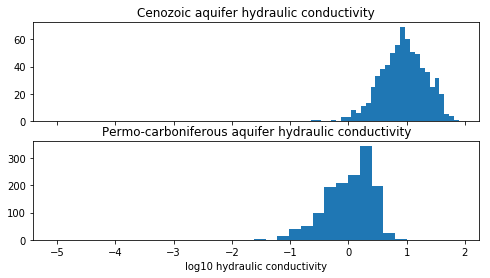

In [28]:
# Plot the histograms for all the aquifers

fig, ax_array = plt.subplots(2,1, figsize = (8,4), sharex = True)


ax_array[0].hist(np.log10(df_SNMR_inversions_nonzero[ceno_mask]['K'].values),
                 bins = 30)
ax_array[0].set_title('Cenozoic aquifer hydraulic conductivity')

ax_array[1].hist(np.log10(df_SNMR_inversions_nonzero[pcarb_mask]['K'].values),
                 bins = 30)
ax_array[1].set_title('Permo-carboniferous aquifer hydraulic conductivity')

#ax_array[2].hist(np.log10(df_SNMR_inversions_nonzero[mill_mask]['K'].values),
#                 bins = 30)
#ax_array[2].set_title('Milligans zone hydraulic conductivity')

ax_array[1].set_xlabel('log10 hydraulic conductivity')

plt.savefig(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\aquifer_histogram_dgal.png")
plt.show()

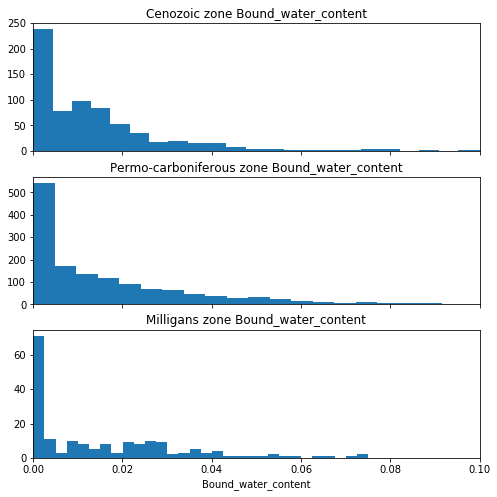

In [103]:
# Plot the histograms for all the aquifers

variable = 'Bound_water_content'

fig, ax_array = plt.subplots(3,1, figsize = (8,8), sharex = True)


ax_array[0].hist(df_SNMR_inversions[ceno_mask][variable].values,
                 bins = 30)
ax_array[0].set_title('Cenozoic zone '  + variable)

ax_array[1].hist(df_SNMR_inversions[pcarb_mask][variable].values,
                 bins = 30)
ax_array[1].set_title('Permo-carboniferous zone ' + variable)

ax_array[2].hist(df_SNMR_inversions[mill_mask][variable].values,
                 bins = 30)
ax_array[2].set_title('Milligans zone ' + variable)

ax_array[2].set_xlabel(variable)

ax_array[2].set_xlim([0,0.1])

plt.savefig(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\\" \
            + variable + "_histogram.png")
plt.show()

In [104]:
# Export

outdir= r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\data"

outfile = os.path.join(outdir, "EK_SNMR_labelled.csv")

df_SNMR_inversions.to_csv(outfile)

In [105]:
# Now we average all the K values in log space for each hydrostratigraphic unit
# for each bore

# Get the log K
df_SNMR_inversions_nonzero['log_K'] = np.log10(df_SNMR_inversions_nonzero['K'])

# Remove 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


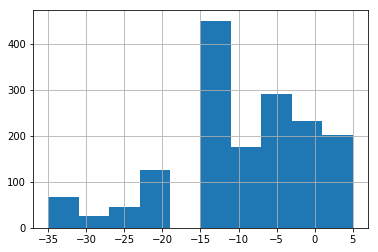

In [106]:
df_SNMR_inversions_nonzero['base_ceno'].hist()

In [107]:
#
for unit in df_SNMR_inversions.label.unique():
    # Export each individual units to a csv
    mask = df_SNMR_inversions.label == unit
    
                          
    df_strat = df_SNMR_inversions[mask]
    
    # Export to csv
    outfile = os.path.join(outdir, unit + "_SNMR_inversion_results.csv")
    df_strat.to_csv(outfile)
    
    # Now we also want to average the log10 conductivity for each unit at each site
    mask = df_strat['K'] != 0
    
    # Get log10 K
    df_strat = df_strat[mask]
    
    if len(df_strat) > 0:
    
        df_strat['log_K'] = np.log10(df_strat['K'])
    
        # Now group by acquisition id and find the median
    
        df_strat_ave = df_strat.groupby(['acquisition_id']).median()
    
        # Export to csv
        outfile = os.path.join(outdir, unit + "_median_observation.csv")
        df_strat_ave.to_csv(outfile)
    

In [108]:
df_strat

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,...,pulse_length,Depth_of_Investigation,wt_mAHD,base_ceno,top_mill,Elevation_from,Elevation_to,label,K,log_K
table_id,,,,,,,,,,,,,,,,,,,,,
18428,40.228938,43.696072,0.073699,0.024522,0.098221,0.262340,376,368,221,OK18_34,...,80.0,71.189093,11.712631,-15.0,-25.0,-24.362718,-27.829852,transition,1.752178,0.243578
19823,25.614455,28.192076,0.064173,0.011513,0.075686,0.113516,404,396,249,OK18_63,...,80.0,71.189093,9.436611,5.0,0.0,0.694560,-1.883061,transition,0.584229,-0.233417
19928,40.228938,43.696072,0.038592,0.020840,0.059432,0.146089,406,398,251,OK18_64,...,80.0,71.189093,12.448536,5.0,-15.0,-12.727727,-16.194861,transition,0.590405,-0.228850
20374,28.192076,30.937070,0.049303,0.006673,0.055975,0.163483,415,407,261,OK18_70,...,80.0,71.189093,9.096518,5.0,-10.0,-8.708428,-11.453422,transition,0.622265,-0.206025
